# TED - Classification

In [17]:
import urllib.request
import zipfile
import lxml.etree

import numpy as np
import os
from random import shuffle
import re

from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
import matplotlib.pyplot as plt
output_notebook()

Loading BokehJS ...

### Pre-Processing

In [18]:
# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

In [19]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
texts = doc.xpath('//content/text()')
keywords = doc.xpath('//keywords/text()')
del doc

In [20]:
print(len(texts))
print(texts[0][:250])

2085
Here are two reasons companies fail: they only do more of the same, or they only do what's new.
To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but 


In [21]:
def keywordsToLabel(keywords):
    label = ['o','o','o']
    keywords_lower = [k.strip().lower() for k in keywords.split(',')]
    
    if 'technology' in keywords_lower:
        label[0] = 'T'
    if 'entertainment' in keywords_lower:
        label[1] = 'E'
    if 'design' in keywords_lower:
        label[2] = 'D'
    
    return "".join(label)

def labelToBinary(label):
    binary_encoding = [0, 0, 0]
    binary_encoding[0] = 1 if label[0] == 'T' else 0
    binary_encoding[1] = 1 if label[1] == 'E' else 0
    binary_encoding[2] = 1 if label[2] == 'D' else 0
    return binary_encoding

def labelToOneHot(label):
    lookup = {
        "ooo": np.array([1,0,0,0,0,0,0,0]),
        "Too": np.array([0,1,0,0,0,0,0,0]),
        "oEo": np.array([0,0,1,0,0,0,0,0]),
        "ooD": np.array([0,0,0,1,0,0,0,0]),
        "TEo": np.array([0,0,0,0,1,0,0,0]),
        "ToD": np.array([0,0,0,0,0,1,0,0]),
        "oED": np.array([0,0,0,0,0,0,1,0]),
        "TED": np.array([0,0,0,0,0,0,0,1])
    }
    
    return lookup[label]

def labelToColor(label):
    lookup = {
        0: 'gray',
        1: 'red',
        2: 'green',
        3: 'yellow',
        4: 'blue',
        5: 'orange',
        6: 'black',
        7: 'pink'
    }
    return lookup[label]

def oneHotToLabel(oneHot):
    return np.argmax(oneHot)

In [22]:
labels = [keywordsToLabel(k) for k in keywords]

In [23]:
# Stats about labels
from collections import Counter

label_counter = Counter(labels)
print(label_counter)

Counter({'ooo': 1134, 'Too': 389, 'oEo': 173, 'ooD': 158, 'ToD': 137, 'TEo': 37, 'TED': 33, 'oED': 24})


### Preprocessing

In [25]:
texts_processed = []
for text in texts:
    texts_processed.append(text.lower().split())


In [56]:
texts_processed[0]

['here',
 'are',
 'two',
 'reasons',
 'companies',
 'fail:',
 'they',
 'only',
 'do',
 'more',
 'of',
 'the',
 'same,',
 'or',
 'they',
 'only',
 'do',
 "what's",
 'new.',
 'to',
 'me',
 'the',
 'real,',
 'real',
 'solution',
 'to',
 'quality',
 'growth',
 'is',
 'figuring',
 'out',
 'the',
 'balance',
 'between',
 'two',
 'activities:',
 'exploration',
 'and',
 'exploitation.',
 'both',
 'are',
 'necessary,',
 'but',
 'it',
 'can',
 'be',
 'too',
 'much',
 'of',
 'a',
 'good',
 'thing.',
 'consider',
 'facit.',
 "i'm",
 'actually',
 'old',
 'enough',
 'to',
 'remember',
 'them.',
 'facit',
 'was',
 'a',
 'fantastic',
 'company.',
 'they',
 'were',
 'born',
 'deep',
 'in',
 'the',
 'swedish',
 'forest,',
 'and',
 'they',
 'made',
 'the',
 'best',
 'mechanical',
 'calculators',
 'in',
 'the',
 'world.',
 'everybody',
 'used',
 'them.',
 'and',
 'what',
 'did',
 'facit',
 'do',
 'when',
 'the',
 'electronic',
 'calculator',
 'came',
 'along?',
 'they',
 'continued',
 'doing',
 'exactly',

In [57]:
keywords[1]

'talks, Planets, TEDx, bacteria, biology, engineering, environment, evolution, exploration, future, innovation, intelligence, microbiology, nature, potential, science'

### Read Embeddings

In [29]:
EMBEDDING_TYPE = 'glove'

# GLOVE 
if EMBEDDING_TYPE == 'glove':
    with zipfile.ZipFile('../../glove.6B.zip', 'r') as z:
        embeddings = z.open('glove.6B.50d.txt', 'r').readlines()
    embedding_dict = {token[0]: np.array(token[1:], dtype='f')
                  for token in [line.decode("utf-8").split()
                  for line in embeddings] }

# Word2Vec    
elif EMBEDDING_TYPE == 'word2vec':
    input_text_noparens = re.sub(r'\([^)]*\)', '', input_text)
    
    from gensim.models import Word2Vec
    model_ted = Word2Vec(texts, workers=4)
    embedding_dict = {token[0]: np.array(token[1:], dtype='f')
              for token in [line.decode("utf-8").split()
              for line in model_ted] }
    
    

In [ ]:
def similarity(a, b):
    x = embedding_dict[a]
    y = embedding_dict[b]
    
    return np.dot(x,y) / (np.linalg.norm(x) * np.linalg.norm(y))

similarity('man', 'rabbit')

In [39]:
def bag_of_means(words, embedding_dict):
    acc = np.zeros(50)
    count = 0
    for word in words:
        if not word in embedding_dict:
            continue
        acc = acc + embedding_dict[word]
        count += 1

    return acc / (count if count != 0 else 1)

In [34]:
bag_of_means(texts_processed[2], embedding_dict)

array([  3.11172779e-01,   9.19320470e-02,   5.38942383e-02,
        -1.86985099e-01,   3.57221311e-01,   1.70526709e-01,
        -4.23007686e-01,  -1.36836587e-01,  -1.58338013e-01,
        -9.33666142e-03,  -7.60521800e-02,  -6.91556765e-03,
        -3.01861229e-01,  -1.02113847e-01,   4.34536350e-01,
         1.82105558e-01,   9.89273205e-02,  -2.49400916e-02,
        -2.89288889e-01,  -4.06335914e-01,   3.19790139e-02,
         2.09821658e-01,   2.23566107e-01,  -1.98474620e-02,
         1.43510003e-01,  -1.64721025e+00,  -4.24321214e-01,
         3.92119951e-02,   2.96479107e-01,  -2.59996574e-01,
         3.26357047e+00,   2.42304298e-01,  -2.43157307e-01,
        -3.74442728e-01,   2.53361714e-02,  -5.09539532e-02,
         2.17689857e-03,   5.96055038e-02,   3.36093206e-03,
        -1.43582392e-01,  -2.60326770e-01,   1.16611293e-01,
         7.29680376e-02,   2.10733250e-01,  -1.34427738e-02,
         5.63477968e-02,  -2.03875767e-01,  -6.25978696e-02,
        -7.94089394e-02,

### Prepare the Data

In [94]:
#X = np.array([bag_of_means(words,embedding_dict) for words in keywords])
X = np.array([bag_of_means(words,embedding_dict) for words in texts_processed])
Y = np.array([labelToOneHot(label) for label in labels])
Y_binary = np.array([labelToBinary(label) for label in labels])


# Shuffle the data
# np.random.seed(0)
shuffle = np.random.permutation(X.shape[0])
X = X[shuffle]
Y = Y[shuffle]
Y_binary = Y_binary[shuffle]

# Split in Training, Cross-Val, and Test Set
n_train = 1585
n_val = 250
n_test = 250

X_train = X[:n_train]
X_val = X[n_train:n_train + n_val]
X_test = X[n_train + n_val:]

Y_train = Y[:n_train]
Y_binary_train = Y_binary[:n_train]
Y_train_labels = [oneHotToLabel(oneHot) for oneHot in Y_train]
Y_val = Y[n_train:n_train + n_val]
Y_test = Y[n_train + n_val:] 
Y_test_labels = [oneHotToLabel(oneHot) for oneHot in Y_test]

In [100]:
X.shape
print(Y_train[2])
print(Y_binary_train[2])

[0 0 1 0 0 0 0 0]
[0 1 0]


### Plot Document Representations using t-SNE

In [60]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
texts_tsne = tsne.fit_transform(X_train)

label_color = [labelToColor(oneHotToLabel(x)) for x in Y_train]

In [61]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="T-SNE for BOW representations of Text")

source = ColumnDataSource(data=dict(x1=texts_tsne[:,0],
                           x2=texts_tsne[:,1],
                           names=Y_train_labels,
                           color=label_color))

p.scatter(x="x1", y="x2", size=8, source=source, color="color")
#labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
#                  text_font_size="8pt", text_color="#555555",
#                  source=source, text_align='center')
#p.add_layout(labels)

show(p)


### Define Model

In [62]:
import tensorflow as tf

class TEDClassifier:
    def __init__(self, num_classes, embedding_size, batch_size):
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.batch_size = batch_size
        
        # Placeholders
        self.input_x = tf.placeholder(tf.float32, [None, self.embedding_size], name='input_x')
        self.input_y = tf.placeholder(tf.float32, [None, self.num_classes], name='input_y')

        # Hidden Layer
        self.W = tf.Variable(tf.zeros([self.embedding_size, self.embedding_size]), name='W')
        self.b = tf.Variable(tf.zeros([self.embedding_size]), name='b')
        
        self.h = tf.tanh(tf.matmul(self.input_x, self.W) + self.b)
        
        # Output Layer
        self.V = tf.Variable(tf.zeros([self.embedding_size, self.num_classes]), name='V')
        self.c = tf.Variable(tf.zeros([self.num_classes]), name='c')
        self.y = tf.matmul(self.h, self.V) + self.c
        
        # Loss function
        self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(self.y, self.input_y))

        # Tensorflow session
        self.sess = tf.Session()
    
    def fit(self, X, Y):
        # Initialise variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

        n = X.shape[0] # number of datapoints

        train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
        correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.input_y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.sess.run(tf.global_variables_initializer())


        i = 0
        while i < n:
            j = min(i + self.batch_size, n)
            batch = (X[i:j], Y[i:j])

            if i%300 == 0:
                train_accuracy = accuracy.eval(session=self.sess, feed_dict={
                    self.input_x:batch[0], self.input_y: batch[1]})
                # print("step %d, training accuracy %g"%(i, train_accuracy))
            train_step.run(session=self.sess, feed_dict={self.input_x: batch[0], self.input_y: batch[1]})

            # Next batch
            i = j

    
    def predict(self, X):
        y = self.y.eval(session=self.sess, feed_dict={self.input_x:X})        
        classification = tf.argmax(tf.nn.softmax(y), 1)

        return self.sess.run(classification)


### Train the Model

In [46]:
NUM_CLASSES = 8
EMBEDDING_SIZE = 50
BATCH_SIZE = 50

cls = TEDClassifier(NUM_CLASSES, EMBEDDING_SIZE, BATCH_SIZE)
cls.fit(X_train,Y_train)


### Prediction on entire Test Set

In [63]:
# Run Prediction on Test set
prediction = cls.predict(X_test)

# Compute error
num_correctly_classified = np.sum(prediction == Y_test_labels)

accuracy_test = num_correctly_classified / n_test
print(accuracy_test)

0.532


### Learning Curve

In [71]:
accuracies_train = []
accuracies_test = []

step = 20 # Step size in percent

for i in range(100 // step):
    # Use only a subset n <= N_train of the training data (10%, 20%, ...,100%)
    p = (i+1) * step
    n_train_subset = int((p / 100) * n_train)
    
    X_train_subset = X_train[:n_train_subset]
    Y_train_subset = Y_train[:n_train_subset]
    
    Y_train_subset_labels = Y_train_labels[:n_train_subset]
    
    # Initialise new classifier 
    cls = TEDClassifier(NUM_CLASSES, EMBEDDING_SIZE, BATCH_SIZE)
    
    # Train on X_subset as training data
    print('Train model using {}% of the training set.'.format(p), end='')
    cls.fit(X_train_subset, Y_train_subset)
    print(u'\t ✓')
    
    # Compute accuracies on test and train set
    pred_train = cls.predict(X_train_subset) 
    accuracy_train = np.sum(pred_train == Y_train_subset_labels) / n_train_subset
    print('\tAccuracy (Train): {}%'.format(accuracy_train))
    accuracies_train.append(accuracy_train)
    
    pred_test = cls.predict(X_test) 
    accuracy_test = np.sum(pred_test == Y_test_labels) / n_test
    print('\tAccuracy (Test): {}%'.format(accuracy_test))
    accuracies_test.append(accuracy_test)
    
    
    

Train model using 20% of the training set.	 ✓
	Accuracy (Train): 0.5457413249211357%
	Accuracy (Test): 0.532%
Train model using 40% of the training set.	 ✓
	Accuracy (Train): 0.556782334384858%
	Accuracy (Test): 0.532%
Train model using 60% of the training set.	 ✓
	Accuracy (Train): 0.5457413249211357%
	Accuracy (Test): 0.532%
Train model using 80% of the training set.	 ✓
	Accuracy (Train): 0.555205047318612%
	Accuracy (Test): 0.532%
Train model using 100% of the training set.	 ✓
	Accuracy (Train): 0.5533123028391167%
	Accuracy (Test): 0.532%


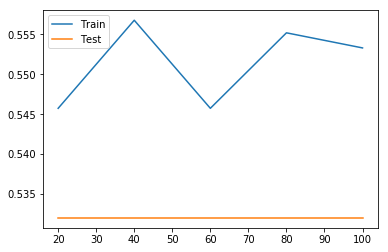

In [85]:
# Plot Learning curve
steps = list(range(step, 100 + step, step))


plt.plot(steps, accuracies_train, label='Train')
plt.plot(steps, accuracies_test, label='Test')
plt.legend()
plt.show()

### Optional: Multi-Class Classification


In [110]:
import tensorflow as tf

class TEDMultiClassifier:
    def __init__(self, num_classes, embedding_size, batch_size):
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.batch_size = batch_size
        
        # Placeholders
        self.input_x = tf.placeholder(tf.float32, [None, self.embedding_size], name='input_x')
        self.input_y = tf.placeholder(tf.float32, [None, self.num_classes], name='input_y')

        # Hidden Layer
        self.W = tf.Variable(tf.zeros([self.embedding_size, self.embedding_size]), name='W')
        self.b = tf.Variable(tf.zeros([self.embedding_size]), name='b')
        
        self.h = tf.tanh(tf.matmul(self.input_x, self.W) + self.b)
        
        # Output Layer
        self.V = tf.Variable(tf.zeros([self.embedding_size, self.num_classes]), name='V')
        self.c = tf.Variable(tf.zeros([self.num_classes]), name='c')
        self.y = tf.matmul(self.h, self.V) + self.c
        
        # Loss function
        self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(self.y, self.input_y))

        # Tensorflow session
        self.sess = tf.Session()
    
    def fit(self, X, Y):
        # Initialise variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

        n = X.shape[0] # number of datapoints

        train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
        correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.input_y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.sess.run(tf.global_variables_initializer())


        i = 0
        while i < n:
            j = min(i + self.batch_size, n)
            batch = (X[i:j], Y[i:j])

            if i%300 == 0:
                train_accuracy = accuracy.eval(session=self.sess, feed_dict={
                    self.input_x:batch[0], self.input_y: batch[1]})
                print("step %d, training accuracy %g"%(i, train_accuracy))
            train_step.run(session=self.sess, feed_dict={self.input_x: batch[0], self.input_y: batch[1]})

            # Next batch
            i = j

    
    def predict(self, X):
        y = self.y.eval(session=self.sess, feed_dict={self.input_x:X})        
        classification = tf.nn.sigmoid(y)

        return self.sess.run(classification) >= 0.5



In [111]:
NUM_CLASSES = 3
EMBEDDING_SIZE = 50
BATCH_SIZE = 50

cls_multi = TEDMultiClassifier(NUM_CLASSES, EMBEDDING_SIZE, BATCH_SIZE)
cls_multi.fit(X_train, Y_binary_train)

step 0, training accuracy 0.82
step 300, training accuracy 0.92
step 600, training accuracy 0.82
step 900, training accuracy 0.74
step 1200, training accuracy 0.8
step 1500, training accuracy 0.88


In [108]:
cls.predict(X_train)

FailedPreconditionError: Attempting to use uninitialized value c_70
	 [[Node: c_70/read = Identity[T=DT_FLOAT, _class=["loc:@c_70"], _device="/job:localhost/replica:0/task:0/cpu:0"](c_70)]]

Caused by op 'c_70/read', defined at:
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-89-26f40754ba41>", line 5, in <module>
    cls = TEDClassifier(NUM_CLASSES, EMBEDDING_SIZE, BATCH_SIZE)
  File "<ipython-input-62-f19c92f7ad9f>", line 21, in __init__
    self.c = tf.Variable(tf.zeros([self.num_classes]), name='c')
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 224, in __init__
    expected_shape=expected_shape)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 370, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1424, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "//anaconda/envs/ox-dl-py3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value c_70
	 [[Node: c_70/read = Identity[T=DT_FLOAT, _class=["loc:@c_70"], _device="/job:localhost/replica:0/task:0/cpu:0"](c_70)]]
